#                                计算机视觉的应用

## 概述

计算机视觉是当前深度学习研究最广泛、落地最成熟的技术领域，在手机拍照、智能安防、自动驾驶等场景有广泛应用。从2012年AlexNet在ImageNet比赛夺冠以来，深度学习深刻推动了计算机视觉领域的发展，当前最先进的计算机视觉算法几乎都是深度学习相关的。深度神经网络可以逐层提取图像特征，并保持局部不变性，被广泛应用于分类、检测、分割、跟踪、检索、识别、提升、重建等视觉任务中。
本次体验结合图像分类任务，介绍MindSpore如何应用于计算机视觉场景，如何训练模型，得出一个性能较优的模型。


## 图像分类

图像分类是最基础的计算机视觉应用，属于有监督学习类别。给定一张数字图像，判断图像所属的类别，如猫、狗、飞机、汽车等等。用函数来表示这个过程如下：

```python
def classify(image):
   label = model(image)
   return label
```

定义的分类函数，以图片数据`image`为输入，通过`model`方法对`image`进行分类，最后返回分类结果。选择合适的`model`是关键。这里的`model`一般指的是深度卷积神经网络，如AlexNet、VGG、GoogLeNet、ResNet等等。  
下面按照MindSpore的训练数据模型的正常步骤进行，当使用到MindSpore或者图像分类操作时，会增加相应的说明，本次体验的整体流程如下：

1. 数据集的准备，这里使用的是CIFAR-10数据集。

2. 构建一个卷积神经网络，这里使用ResNet-50网络。

3. 定义损失函数和优化器。

4. 调用Model高阶API进行训练和保存模型文件。

5. 进行模型精度验证。

> 本文档适用于GPU和Ascend环境。

## 训练数据集下载

### 数据集准备

In [1]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
!unzip -o cifar10.zip -d ./datasets
!tree ./datasets/cifar10

--2020-12-04 11:34:20--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar10.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 166235630 (159M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 158.53M  56.2MB/s    in 2.8s    

2020-12-04 11:34:23 (56.2 MB/s) - ‘cifar10.zip’ saved [166235630/166235630]

Archive:  cifar10.zip
   creating: ./datasets/cifar10/
   creating: ./datasets/cifar10/test/
  inflating: ./datasets/cifar10/test/test_batch.bin  
   creating: ./datasets/cifar10/train/
  inflating: ./datasets/cifar10/train/batches.meta.txt  
  inflating: ./datasets/cifar10/train/data_batch_1.bin  
  inflating: ./datasets/cifar10/train/data_batch_2.bin  
  inflating: ./data

### 数据处理

数据集处理对于训练非常重要，好的数据集可以有效提高训练精度和效率。在加载数据集前，我们通常会对数据集进行一些处理。这里我们用到了数据增强，数据混洗和批处理。

数据增强主要是对数据进行归一化和丰富数据样本数量。常见的数据增强方式包括裁剪、翻转、色彩变化等等。MindSpore通过调用`map`方法在图片上执行增强操作。数据混洗和批处理主要是通过数据混洗`shuffle`随机打乱数据的顺序，并按`batch`读取数据，进行模型训练。

构建`create_dataset`函数，来创建数据集。通过设置` resize_height`、`resize_width`、`rescale`、`shift`参数，定义`map`以及在图片上运用`map`实现数据增强。

The dataset size is: 1562
The batch tensor is: (32, 3, 224, 224)


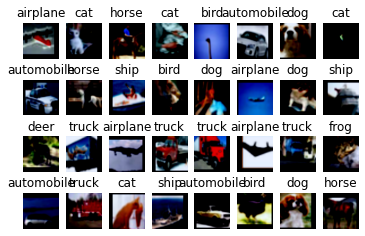

In [2]:
import mindspore.nn as nn
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.transforms.c_transforms as C2
from mindspore import context
import numpy as np
import matplotlib.pyplot as plt

context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

def create_dataset(data_home, repeat_num=1, batch_size=32, do_train=True, device_target="GPU"):
    """
    create data for next use such as training or inferring
    """

    cifar_ds = ds.Cifar10Dataset(data_home,num_parallel_workers=8, shuffle=True)

    c_trans = []
    if do_train:
        c_trans += [
            C.RandomCrop((32, 32), (4, 4, 4, 4)),
            C.RandomHorizontalFlip(prob=0.5)
        ]

    c_trans += [
        C.Resize((224, 224)),
        C.Rescale(1.0 / 255.0, 0.0),
        C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        C.HWC2CHW()
    ]

    type_cast_op = C2.TypeCast(mstype.int32)

    cifar_ds = cifar_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=8)
    cifar_ds = cifar_ds.map(operations=c_trans, input_columns="image", num_parallel_workers=8)

    cifar_ds = cifar_ds.batch(batch_size, drop_remainder=True)
    cifar_ds = cifar_ds.repeat(repeat_num)

    return cifar_ds


ds_train_path = "./datasets/cifar10/train/"
dataset_show = create_dataset(ds_train_path)
with open(ds_train_path+"batches.meta.txt","r",encoding="utf-8") as f:
    all_name = [name.replace("\n","") for name in f.readlines()]

iterator_show= dataset_show.create_dict_iterator()
dict_data = next(iterator_show)
images = dict_data["image"].asnumpy()
labels = dict_data["label"].asnumpy()
count = 1
%matplotlib inline
for i in images:
    plt.subplot(4, 8, count)
    # Images[0].shape is (3,224,224).We need transpose as (224,224,3) for using in plt.show().
    picture_show = np.transpose(i,(1,2,0))
    picture_show = picture_show/np.amax(picture_show)
    picture_show = np.clip(picture_show, 0, 1)
    plt.title(all_name[labels[count-1]])
    picture_show = np.array(picture_show,np.float32)
    plt.imshow(picture_show)
    count += 1
    plt.axis("off")

print("The dataset size is:", dataset_show.get_dataset_size())
print("The batch tensor is:",images.shape)
plt.show()

数据集生成后，选取一个`batch`的图像进行可视化查看，经过数据增强后，原数据集变成了每个batch张量为，共计1572个batch的新数据集。

## 定义卷积神经网络

卷积神经网络已经是图像分类任务的标准算法了。卷积神经网络采用分层的结构对图片进行特征提取，由一系列的网络层堆叠而成，比如卷积层、池化层、激活层等等。
ResNet-50通常是较好的选择。首先，它足够深，常见的有34层，50层，101层。通常层次越深，表征能力越强，分类准确率越高。其次，可学习，采用了残差结构，通过shortcut连接把低层直接跟高层相连，解决了反向传播过程中因为网络太深造成的梯度消失问题。此外，ResNet-50网络的性能很好，既表现为识别的准确率，也包括它本身模型的大小和参数量。

下载构建好的resnet50网络源码文件。

In [3]:
!wget -N https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/source-codes/resnet.py

--2020-12-04 11:34:29--  https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/source-codes/resnet.py
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 9533 (9.3K) [binary/octet-stream]
Saving to: ‘resnet.py’

resnet.py           100%[===================>]   9.31K  --.-KB/s    in 0s      

2020-12-04 11:34:29 (160 MB/s) - ‘resnet.py’ saved [9533/9533]



下载下来的`resnet.py`在当前目录，可以使用`import`方法将resnet50网络导出。

In [4]:
from resnet import resnet50

net = resnet50(batch_size=32, num_classes=10)

## 定义损失函数和优化器

接下来需要定义损失函数（Loss）和优化器（Optimizer）。损失函数是深度学习的训练目标，也叫目标函数，可以理解为神经网络的输出（Logits）和标签(Labels)之间的距离，是一个标量数据。
常见的损失函数包括均方误差、L2损失、Hinge损失、交叉熵等等。图像分类应用通常采用交叉熵损失（CrossEntropy）。
优化器用于神经网络求解（训练）。由于神经网络参数规模庞大，无法直接求解，因而深度学习中采用随机梯度下降算法（SGD）及其改进算法进行求解。MindSpore封装了常见的优化器，如SGD、ADAM、Momemtum等等。本例采用Momentum优化器，通常需要设定两个参数，动量（moment）和权重衰减项（weight decay）。

通过调用MindSpore中的API：`Momentum`和`SoftmaxCrossEntropyWithLogits`，设置损失函数和优化器的参数。

In [5]:
import mindspore.nn as nn
from mindspore.nn import SoftmaxCrossEntropyWithLogits

ls = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
opt = nn.Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)

## 调用Model高阶API进行训练和保存模型文件

完成数据预处理、网络定义、损失函数和优化器定义之后，就可以进行模型训练了。模型训练包含两层迭代，数据集的多轮迭代（epoch）和一轮数据集内按分组（batch）大小进行的单步迭代。其中，单步迭代指的是按分组从数据集中抽取数据，输入到网络中计算得到损失函数，然后通过优化器计算和更新训练参数的梯度。

为了简化训练过程，MindSpore封装了Model高阶接口。用户输入网络、损失函数和优化器完成Model的初始化，然后调用`train`接口进行训练，`train`接口参数包括迭代次数`epoch`和数据集`dataset`。

模型保存是对训练参数进行持久化的过程。`Model`类中通过回调函数的方式进行模型保存，如下面代码所示。用户通过`CheckpointConfig`设置回调函数的参数，其中，`save_checkpoint_steps`指每经过固定的单步迭代次数保存一次模型，`keep_checkpoint_max`指最多保存的模型个数。

本次体验选择`epoch_size`为10，一共迭代了10次，得到如下的运行结果。体验者可以自行设置不同的`epoch_size`，生成不同的模型，在下面的验证部分查看模型精确度。

In [6]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import load_checkpoint, load_param_into_net
import os
from mindspore import Model


model = Model(net, loss_fn=ls, optimizer=opt, metrics={'acc'})
# As for train, users could use model.train

epoch_size = 10
ds_train_path = "./datasets/cifar10/train/"
model_path = "./models/ckpt/mindspore_vision_application/"
os.system('rm -f {0}*.ckpt {0}*.meta {0}*.pb'.format(model_path))

dataset = create_dataset(ds_train_path )
batch_num = dataset.get_dataset_size()
config_ck = CheckpointConfig(save_checkpoint_steps=batch_num, keep_checkpoint_max=35)
ckpoint_cb = ModelCheckpoint(prefix="train_resnet_cifar10", directory=model_path, config=config_ck)
loss_cb = LossMonitor(142)
model.train(epoch_size, dataset, callbacks=[ckpoint_cb, loss_cb])

epoch: 1 step: 142, loss is 2.041043
epoch: 1 step: 284, loss is 1.7856436
epoch: 1 step: 426, loss is 1.5305918
epoch: 1 step: 568, loss is 1.7724597
epoch: 1 step: 710, loss is 1.3827077
epoch: 1 step: 852, loss is 1.2597129
epoch: 1 step: 994, loss is 1.7239776
epoch: 1 step: 1136, loss is 1.5275167
epoch: 1 step: 1278, loss is 1.5193802
epoch: 1 step: 1420, loss is 1.2839599
epoch: 1 step: 1562, loss is 1.2304927
epoch: 2 step: 142, loss is 1.3567938
epoch: 2 step: 284, loss is 0.9500004
epoch: 2 step: 426, loss is 1.022787
epoch: 2 step: 568, loss is 1.1582599
epoch: 2 step: 710, loss is 0.96332455
epoch: 2 step: 852, loss is 1.0251642
... ...
epoch: 10 step: 426, loss is 0.15948972
epoch: 10 step: 568, loss is 0.30928737
epoch: 10 step: 710, loss is 0.26390004
epoch: 10 step: 852, loss is 0.33643064
epoch: 10 step: 994, loss is 0.38283178
epoch: 10 step: 1136, loss is 0.26065817
epoch: 10 step: 1278, loss is 0.48519582
epoch: 10 step: 1420, loss is 0.43286812
epoch: 10 step: 1562

查询训练过程中，保存好的模型。

In [7]:
!tree ./models/ckpt/mindspore_vision_application/

./models/ckpt/mindspore_vision_application/
├── train_resnet_cifar10-10_1562.ckpt
├── train_resnet_cifar10-1_1562.ckpt
├── train_resnet_cifar10-2_1562.ckpt
├── train_resnet_cifar10-3_1562.ckpt
├── train_resnet_cifar10-4_1562.ckpt
├── train_resnet_cifar10-5_1562.ckpt
├── train_resnet_cifar10-6_1562.ckpt
├── train_resnet_cifar10-7_1562.ckpt
├── train_resnet_cifar10-8_1562.ckpt
├── train_resnet_cifar10-9_1562.ckpt
└── train_resnet_cifar10-graph.meta

0 directories, 11 files


每1562个step保存一次模型权重参数`.ckpt`文件，一共保存了10个，另外`.meta`文件保存模型的计算图信息。

## 进行模型精度验证

调用`model.eval`得到最终精度数据约为0.80远高于0.5，准确度较高，验证得出模型是性能较优的。

In [8]:
# As for evaluation, users could use model.eval
ds_eval_path = "./datasets/cifar10/test/"
eval_dataset = create_dataset(ds_eval_path, do_train=False)
res = model.eval(eval_dataset)
print("result: ", res)

result:  {'acc': 0.8001802884615384}


## 总结

本次体验，带领体验者了解了MindSpore的卷积神经网络ResNet-50，通过构建ResNet-50对CIFAR-10进行分类。可以看出MindSpore的ResNet-50的构建非常容易，损失函数和优化器都有封装好的API，对于初学者和研发人员都非常的友善。